# Notebook to create a dataset

In [ ]:
!pip install sqlalchemy==1.4.54

In [2]:
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import seisbench.util as sbu
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import torch
from torch.utils.data import DataLoader
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as ex
import plotly.graph_objects as go 
from obspy.clients.fdsn.header import FDSNException
from pathlib import Path
import requests
from obspy.core.event import read_events
client = Client('IRIS')

## Get the catalog

- A catalog is an object that contains the events of our interest that we request using the parameters we specify. you can find the list of the parameters and their meanings [here](https://service.iris.edu/irisws/mars-event/docs/1/help/). 

- Create the query link by specifing the parameters you want using this [URL builder](https://service.iris.edu/irisws/mars-event/docs/1/builder/) and paste it in the `link` variable.
- **Make sure that `Preferred Origins Only`, `Preferred Magnitudes Only`, `Include Arrivals` are all checked and the formal is 'XML(QuakeML)'**.
- Events will be written in `events.xml` file
- Last thing `events.xml` will be read using `obspy.core.event.read_events()`.

In [5]:
link = "https://service.iris.edu/irisws/mars-event/1/query?starttime=2022-01-01T00:00:00&endtime=2023-01-31T00:00:00&magnitudetype=MbS,MbP,MW&eventtype=BB,HF&lo\
cationquality=A,B&includeallorigins=false&includeallmagnitudes=false&includearrivals=true&orderby=time-asc&format=xml&nodata=204"
r = requests.get(link)
r

<Response [200]>

In [6]:
with open ("events.xml" , 'w') as f : 
    f.write(r.text)

In [3]:
catalog= read_events("events.xml")

## Set the parameters we extract 
- The event object contains the metadata for the events. we will keep *some* of them for later use or analysis.
- There are 3 objects in each event that we are interested in `origin` , `magnitude`, `picks`.
- `origin` and `magnitude`: Both contain metadata about how the event like magnitude, time, longtiude and latitude, etc...
- `picks`: This is our list of interest. picks contains all the activities that were labled like "P" and "S" picks among several other pick types.
- The commented part is for adding a split column to our metadata. This will be convients when trainig/testing. When you choose a time period you can uncomment the code and change the dates to split according to your needs.  

Note: picks from mars are manually labled from "MQS"

In [4]:
def get_event_params(event):
    origin = event.preferred_origin()
    mag = event.preferred_magnitude()
    source_id = str(event.resource_id)
    event_params={
        'source_id': source_id,
        'latitude': origin['latitude'] if origin['latitude'] is not None else None,
        'latitude_errors':origin['latitude_errors']['uncertainty'] if origin['latitude_errors'] is not None else None,
        'longitude': origin['longitude'] if origin['longitude'] is not None else None,
        'longitude_errors': origin['longitude_errors']['uncertainty'] if origin['longitude_errors'] is not None else None,
        'depth': origin['depth'] if origin['depth']  is not None else None,
        'depth_errors': origin['depth_errors']['uncertainty'] if origin['depth_errors'] is not None else None,
        'depth_type':origin['depth_type'] if origin['depth_type']  is not None else None,
        'origin_evaluation_mode': origin['evaluation_mode'] if origin['evaluation_mode'] is not None else None,
        'origievaluation_status': origin['evaluation_status'] if origin['evaluation_status'] is not None else None,
        'time': origin['time'] if origin['time']  is not None else None,
        'region': origin['region'] if origin['region'] is not None else None,
      }
    if mag is not None:
        event_params['mag'] =  mag['mag'] if mag['mag'] is not None else None
        event_params['mag_errors'] =  mag['mag_errors']['uncertainty'] if mag['mag_errors'] is not None else None
        event_params['magnitude_type'] = mag['magnitude_type'] if mag['magnitude_type'] is not None else None
        event_params['creation_info'] =  mag['creation_info'] if mag['creation_info'] is not None else None
        event_params['evaluation_mode'] = mag['evaluation_mode'] if mag['evaluation_mode'] is not None else None
        event_params['evaluation_status'] = mag['evaluation_status'] if mag['evaluation_status'] is not None else None
    
    if origin.time < "2022-01-20":
      split = 'train'
    elif origin.time<'2022-01-23':
      split = 'val'
    else:
      split = 'test'
    
    event_params["split"] = split
    
    return event_params


def get_trace_params(pick):
  net = pick.waveform_id.network_code
  sta = pick.waveform_id.station_code

  trace_params={
      'station_network_code':net,
      "station_code":sta,
      "trace_channel":pick.waveform_id.channel_code[:2],
      'station_location_code': pick.waveform_id.location_code,
  }
  return trace_params

def get_waveforms(pick , trace_params, time_before=60, time_after=60 , pairs = False):
    if pairs :
        t_start , t_end = pick[0].time-time_before ,  pick[1].time+time_after
    else :
        t_start , t_end = pick.time-time_before , pick.time+time_after
    try:
        waveforms = client.get_waveforms(
            network=trace_params["station_network_code"],
            station=trace_params["station_code"],
            location=trace_params['station_location_code'],
            channel=f"{trace_params['trace_channel']}*",
            starttime=t_start,
            endtime=t_end,
        )
    except FDSNException:
        # Return empty stream
        waveforms = obspy.Stream()

    return waveforms


In [5]:
def get_picks (event): 
    list_of_picks=  ['P', 'S','p','s','Pg','Sg','pP','P1','Pn',"PmP","pwP",'pwPm', 'S1','SmS','Sn']
    picks = [x for x in event.picks if x.phase_hint in list_of_picks]
    picks = [[picks[i],picks[i+1]] for i in range (0 , len(picks),2) ]
    return sorted( picks[0] , key = lambda x: x.time)  

these convience functions I made to deal with seisbench framework

In [6]:
def switch_UVW_to_ZNE(stream): 
    conv = {'U': 'Z', 'V':'N' , "W": "E"}
    for i in stream: 
        i.stats.channel = i.stats.channel[:-1]+ conv[i.stats.channel[-1]]
    return stream
def switch_ZNE_to_UVW(stream): 
    conv = {'Z': 'U', 'N':'V' , "E": "W"}
    for i in stream: 
        i.stats.channel = i.stats.channel[:-1]+ conv[i.stats.channel[-1]]
    return stream

## Write data 

We write the data into 2 files `metadata.csv` and `waveforms.hdf5`. As the names imply the `metadata.csv` contain all the metadata we extracted and `waveforms.hdf5` contains the raw waveforms themselves. This is the strucutre that seisbench want so we are just going to go with it.

In [7]:
base_path = Path('.')
metadata_path = base_path/"metadata.csv"
waveforms_path = base_path/'waveforms.hdf5'

In [8]:
with sbd.WaveformDataWriter(metadata_path, waveforms_path) as writer:
    # Define data format
    writer.data_format = {
        "dimension_order": "CW",
        "component_order": "ZNE",
        "measurement": "velocity",
        "unit": "counts",
        "instrument_response": "not restituted",
    }
    
    for event in catalog:
        event_params = get_event_params(event)
        picks = [get_picks(event)]
        for pick in picks :

            trace_params = get_trace_params(pick[0])
            waveforms = get_waveforms(pick, trace_params , pairs = True )
            
            if len(waveforms) == 0:
                # No waveform data available
                continue
        
            sampling_rate = waveforms[0].stats.sampling_rate
            # Check that the traces have the same sampling rate
            assert all(trace.stats.sampling_rate == sampling_rate for trace in waveforms)
            waveforms = switch_UVW_to_ZNE(waveforms)
            actual_t_start, data, _ = sbu.stream_to_array(
                    waveforms,
                    component_order="ZNE",
                )
            
            trace_params["trace_sampling_rate_hz"] = sampling_rate
            trace_params["trace_start_time"] = str(actual_t_start)
            
            sample1 = (pick[0].time - actual_t_start) * sampling_rate
            sample2 = (pick[1].time - actual_t_start) * sampling_rate
        
            trace_params[f"trace_{pick[0].phase_hint}_arrival_sample"] = int(sample1)
            trace_params[f"trace_{pick[0].phase_hint}_status"] = pick[0].evaluation_mode
            trace_params[f"trace_{pick[1].phase_hint}_arrival_sample"] = int(sample2)
            trace_params[f"trace_{pick[1].phase_hint}_status"] = pick[1].evaluation_mode
            
            writer.add_trace({**event_params, **trace_params}, data)

Traces converted: 9it [00:20,  2.24s/it]


## Read data

read data using seisbench `WaveformDataset` we can choose our sampling rate if we want to upsample or downsample in advance.

In [9]:
data = sbd.WaveformDataset(base_path)

2024-10-03 00:07:31,049 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


In [10]:
data.metadata

,index,source_id,latitude,latitude_errors,longitude,longitude_errors,depth,depth_errors,depth_type,origin_evaluation_mode,...,trace_P_status,trace_S_arrival_sample,trace_S_status,trace_name,trace_Pg_arrival_sample,trace_Pg_status,trace_Sg_arrival_sample,trace_Sg_status,trace_chunk,trace_component_order
0,0,smi:insight.mqs/mqs2022aceh,16.604015,NaN,61.713564,NaN,NaN,NaN,NaN,manual,...,manual,9557.0,manual,bucket0,NaN,NaN,NaN,NaN,,ZNE
1,1,smi:insight.mqs/mqs2022ahxv,4.502400,NaN,135.623400,NaN,NaN,NaN,NaN,manual,...,NaN,NaN,NaN,bucket1,1199.0,manual,6046.0,manual,,ZNE
2,2,smi:insight.mqs/mqs2022cixp,3.388579,NaN,165.862935,NaN,NaN,NaN,NaN,manual,...,manual,4703.0,manual,"bucket2$0,:3,:5904",NaN,NaN,NaN,NaN,,ZNE
3,3,smi:insight.mqs/mqs2022dulj,4.502400,NaN,135.623400,NaN,NaN,NaN,NaN,manual,...,manual,10439.0,manual,"bucket3$0,:3,:11640",NaN,NaN,NaN,NaN,,ZNE
4,4,smi:insight.mqs/mqs2022eaft,4.502400,NaN,135.623400,NaN,NaN,NaN,NaN,manual,...,manual,5312.0,manual,"bucket2$1,:3,:6514",NaN,NaN,NaN,NaN,,ZNE
5,5,smi:insight.mqs/mqs2022endd,4.502400,NaN,135.623400,NaN,NaN,NaN,NaN,manual,...,NaN,NaN,NaN,"bucket4$0,:3,:7401",1199.0,manual,6200.0,manual,,ZNE
6,6,smi:insight.mqs/mqs2022gytb,4.502400,NaN,135.623400,NaN,NaN,NaN,NaN,manual,...,manual,4900.0,manual,"bucket2$2,:3,:6102",NaN,NaN,NaN,NaN,,ZNE
7,7,smi:insight.mqs/mqs2022isne,-2.971128,NaN,171.904395,NaN,NaN,NaN,NaN,manual,...,manual,5485.0,manual,"bucket4$1,:3,:6686",NaN,NaN,NaN,NaN,,ZNE
8,8,smi:insight.mqs/mqs2022wrzi,4.502400,NaN,135.623400,NaN,NaN,NaN,NaN,manual,...,manual,10671.0,manual,"bucket3$1,:3,:11872",NaN,NaN,NaN,NaN,,ZNE


In [11]:
data.metadata.iloc[0]

index                                                0
source_id                  smi:insight.mqs/mqs2022aceh
latitude                                     16.604015
latitude_errors                                    NaN
longitude                                    61.713564
longitude_errors                                   NaN
depth                                              NaN
depth_errors                                       NaN
depth_type                                         NaN
origin_evaluation_mode                          manual
origievaluation_status                        reviewed
time                       2022-01-02T04:27:10.093600Z
region                                             NaN
mag                                                3.2
mag_errors                                         NaN
magnitude_type                                      MW
creation_info                                      NaN
evaluation_mode                                    NaN
evaluation

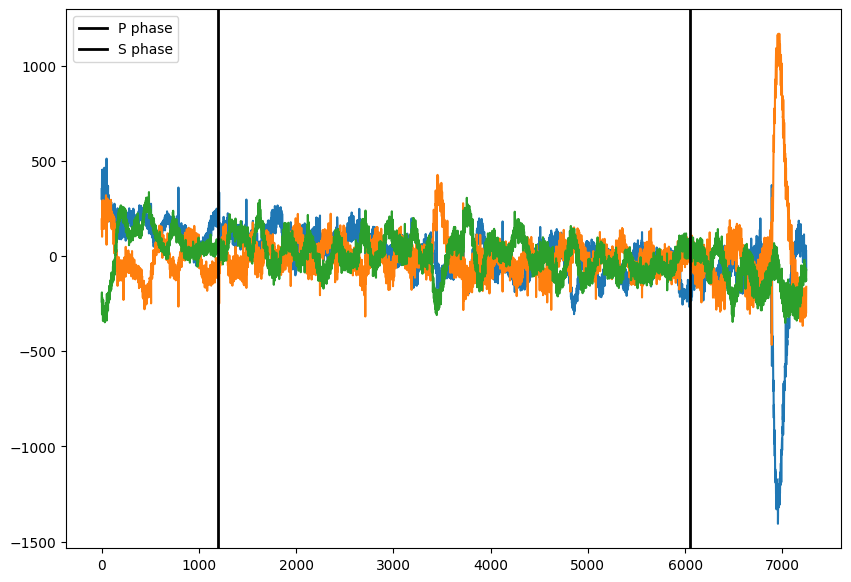

In [12]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(data.get_waveforms(1).T )
ax.axvline(data.metadata.iloc[1]['trace_Pg_arrival_sample'], color="k", lw=2 , label= "P phase")
ax.axvline(data.metadata.iloc[1]['trace_Sg_arrival_sample'], color="k", lw=2 , label= "S phase")
ax.legend()


In [13]:
data.metadata.iloc[0]

index                                                0
source_id                  smi:insight.mqs/mqs2022aceh
latitude                                     16.604015
latitude_errors                                    NaN
longitude                                    61.713564
longitude_errors                                   NaN
depth                                              NaN
depth_errors                                       NaN
depth_type                                         NaN
origin_evaluation_mode                          manual
origievaluation_status                        reviewed
time                       2022-01-02T04:27:10.093600Z
region                                             NaN
mag                                                3.2
mag_errors                                         NaN
magnitude_type                                      MW
creation_info                                      NaN
evaluation_mode                                    NaN
evaluation

In [14]:
generator = sbg.GenericGenerator(data)
dataloader = DataLoader(generator)
